# BNN using MCMC for predicting Band Gaps 

In [1]:
from pyro.infer import MCMC, NUTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from BNN_basic_model import BayesianNN

from sklearn.preprocessing import StandardScaler
import torch.distributions as dist

# Use predictive distribution
from pyro.infer import Predictive

from sklearn.feature_selection import SelectKBest, f_regression



### Read the data 

In [2]:
df_mp = pd.read_csv('/home/april-ai/Desktop/UQ/MP_Data_Corrected/10k_data_cleaned.csv')

In [3]:
df_mp = df_mp[(df_mp['band_gap'] > 0.2)]
y = df_mp['band_gap']

### Train-test split

In [4]:
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites", 'HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element']
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

#print("There are {} possible descriptors:\n\n{}".format(X.shape[1], X.columns.values))

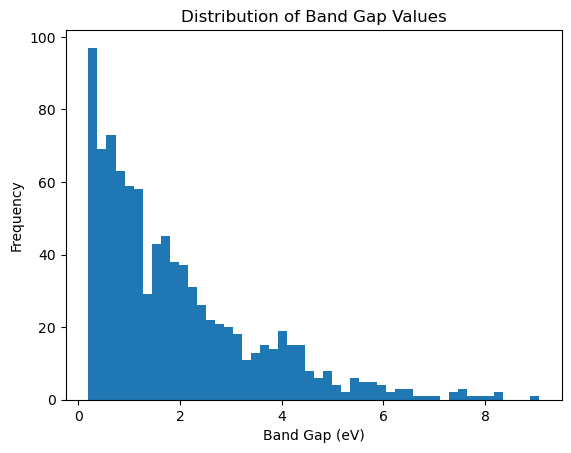

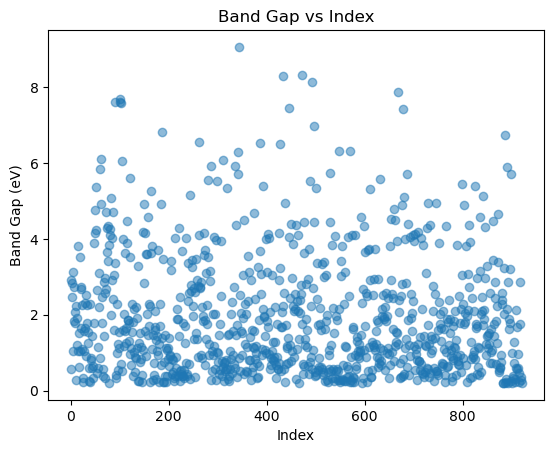

In [5]:
#visualize the distrubution of  the band gap data 

plt.hist(y, bins=50)
plt.xlabel('Band Gap (eV)')
plt.ylabel('Frequency')
plt.title('Distribution of Band Gap Values')
plt.show()

#visualise the bannd gap vs index 
plt.scatter(range(len(y)), y, alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Band Gap (eV)')
plt.title('Band Gap vs Index')
plt.show()

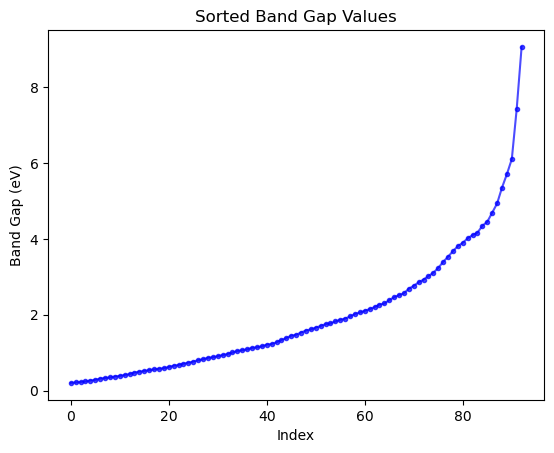

In [6]:
#visualise sorted band gap values
sorted_y = np.sort(y)
plt.plot(sorted_y[: : 10], marker='o', markersize=3, linestyle='-', color='blue', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Band Gap (eV)')
plt.title('Sorted Band Gap Values')
plt.show()

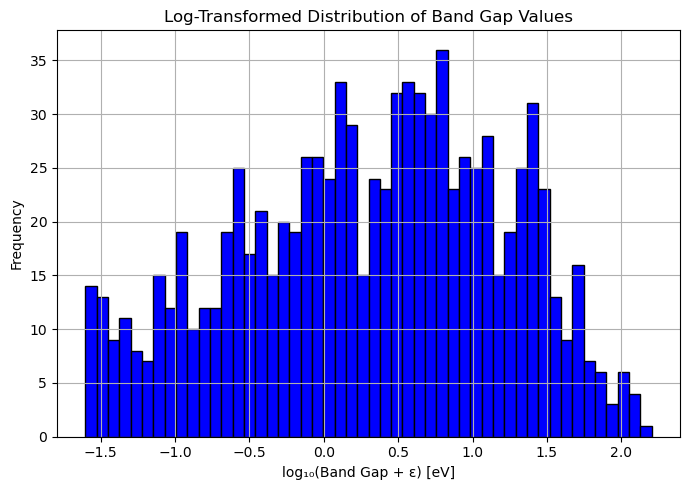

In [7]:
#Log transformed distribution: 
epsilon = 1e-3 #to avoid dividing by zero 
y_log = np.log(y + epsilon)

# Plot histogram of log-transformed band gap values
plt.figure(figsize=(7, 5))
plt.hist(y_log, bins=50, color='blue', edgecolor='black')
plt.xlabel('log₁₀(Band Gap + ε) [eV]')
plt.ylabel('Frequency')
plt.title('Log-Transformed Distribution of Band Gap Values')
plt.grid(True)
plt.tight_layout()
plt.show()


### Data preprocessing

In [8]:

# Drop non-numeric / irrelevant fields
non_feature_cols = [
    "material_id", "composition", "formula_pretty", "symmetry", "structure", "sites", 'HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element'
]
df = df_mp.drop(columns=non_feature_cols, errors='ignore')
df = df.dropna(subset=["band_gap"])

# Save original indices
original_indices = np.arange(len(df))

# Split first — before scaling — and keep track of original indices
X_raw = df.drop(columns=["band_gap"])
y_raw = df["band_gap"]
X_raw = X_raw.replace([np.inf, -np.inf], np.nan)
X_raw = X_raw.fillna(0)

X_train_raw, X_test_raw, y_train_raw, y_test_raw, idx_train, idx_test = train_test_split(
    X_raw, y_raw, original_indices, test_size=0.2, random_state=42
)


#y_train_log = np.log(y_train_raw)
#y_test_log = np.log(y_test_raw)

In [9]:
#print(y_train_log)

In [10]:
# Normalise training data
scaler_x = StandardScaler()
scaler_y = StandardScaler()


X_train = scaler_x.fit_transform(X_train_raw) #computes mean and std from training data and scales it
X_test = scaler_x.transform(X_test_raw) #uses the same mean and std to scale test data




y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).ravel() #ravel() flattens the output back to 1D, which is typically needed for PyTorch models expecting targets as flat vectors.

# Store the selector
selector = SelectKBest(score_func=f_regression, k=100)
X_train_selected = selector.fit_transform(X_train, y_train)

model = BayesianNN(input_dim=X_train_selected.shape[1]) 

mask = selector.get_support()                # boolean mask of selected features
selected_indices = selector.get_support(indices=True)  # or integer indices

selected_feature_names = X_train_raw.columns[mask].tolist()
print(selected_feature_names)


# Convert to Pytorch tensors
#C onverts the NumPy arrays into torch.tensor objects, which are the format needed for training/testing the BNN in PyTorch.
X_train_tensor = torch.tensor(X_train_selected, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(selector.transform(X_test), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

['nsites', 'volume', 'formation_energy_per_atom', 'H', 'Be', 'F', 'Mg', 'Cl', 'transition metal fraction', 'band center', 'MagpieData minimum Number', 'MagpieData maximum Number', 'MagpieData mean Number', 'MagpieData mode Number', 'MagpieData minimum MendeleevNumber', 'MagpieData maximum MendeleevNumber', 'MagpieData mean MendeleevNumber', 'MagpieData mode MendeleevNumber', 'MagpieData minimum AtomicWeight', 'MagpieData maximum AtomicWeight', 'MagpieData mean AtomicWeight', 'MagpieData mode AtomicWeight', 'MagpieData minimum MeltingT', 'MagpieData range MeltingT', 'MagpieData mean MeltingT', 'MagpieData avg_dev MeltingT', 'MagpieData mode MeltingT', 'MagpieData maximum Column', 'MagpieData minimum Row', 'MagpieData maximum Row', 'MagpieData mean Row', 'MagpieData mode Row', 'MagpieData minimum CovalentRadius', 'MagpieData maximum CovalentRadius', 'MagpieData range CovalentRadius', 'MagpieData mean CovalentRadius', 'MagpieData mode CovalentRadius', 'MagpieData maximum Electronegativity

In [11]:
print(len(X_train), len(X_test))

736 185


### MCMC Sample and run the model 

In [ ]:
import importlib
import BNN_model
importlib.reload(BNN_model)
#from BNN_basic_model import BayesianNN
from BNN_model import BayesianNN

In [ ]:
#model = BayesianNN(input_dim=X_train.shape[1])  # Initialise BayesianNN model

nuts_kernel = NUTS(model)  # No-U-Turn Sampler — a smart version of Hamiltonian Monte Carlo (HMC) that avoids manually setting path lengths
#=> performs gradient-based MCMC to sample from the posterior distribution over the model parameters, given data.

#Run MCMC 
mcmc = MCMC(nuts_kernel, num_samples=300, warmup_steps=200)
mcmc.run(X_train_tensor, y_train_tensor) #After: 300 samples from the posterior distribution over the weights and biases of the BNN

posterior_samples = mcmc.get_samples() # dictionary of sampled model parameters (e.g., weights, biases)


Sample:  53%|█████▎    | 267/500 [1:32:29, 64.27s/it, step size=5.79e-03, acc. prob=0.713]

### Make predictions 

In [ ]:

"""

# === Predictive distribution from posterior samples ===
predictive = Predictive(model, posterior_samples, return_sites=["obs"])
preds = predictive(X_test_tensor)["obs"]  # shape: [num_samples, num_test_points]

# === Get predictive mean and std in standardized log space ===
mean_pred = preds.mean(dim=0).numpy()  # [num_test_points]
std_pred = preds.std(dim=0).numpy()

# === Inverse-transform: standardized log → log → actual band gap ===

# Step 1: unstandardize the mean (i.e., bring it back to log space)
mean_pred_log = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()

# Step 2: exponentiate to return to original band gap values (eV)
mean_pred_actual = np.exp(mean_pred_log)

# === Adjust uncertainty: transform std back to original units (approximation) ===

# Step 1: unstandardize std — std transforms linearly under scaling
std_pred_log = std_pred * scaler_y.scale_[0]

# Step 2: approximate std in original scale using delta method:
# Var(Y) ≈ (d/dx exp(x))^2 * Var(X) = (exp(mean))^2 * Var(X)
std_pred_actual = mean_pred_actual * std_pred_log  # because d/dx exp(x) = exp(x)

# === Inverse-transform true y values for evaluation/plotting ===
y_test_log = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_test_actual = np.exp(y_test_log)

# Plot with confidence interval
plt.figure(figsize=(8, 6))
plt.errorbar(np.arange(len(mean_pred_actual)), mean_pred_actual, yerr=2*std_pred_actual, fmt='o', label="Prediction ±2σ", alpha=0.6)
plt.plot(np.arange(len(y_test_actual)), y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()
"""

'\n\n# === Predictive distribution from posterior samples ===\npredictive = Predictive(model, posterior_samples, return_sites=["obs"])\npreds = predictive(X_test_tensor)["obs"]  # shape: [num_samples, num_test_points]\n\n# === Get predictive mean and std in standardized log space ===\nmean_pred = preds.mean(dim=0).numpy()  # [num_test_points]\nstd_pred = preds.std(dim=0).numpy()\n\n# === Inverse-transform: standardized log → log → actual band gap ===\n\n# Step 1: unstandardize the mean (i.e., bring it back to log space)\nmean_pred_log = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()\n\n# Step 2: exponentiate to return to original band gap values (eV)\nmean_pred_actual = np.exp(mean_pred_log)\n\n# === Adjust uncertainty: transform std back to original units (approximation) ===\n\n# Step 1: unstandardize std — std transforms linearly under scaling\nstd_pred_log = std_pred * scaler_y.scale_[0]\n\n# Step 2: approximate std in original scale using delta method:\n# Var(Y) ≈ (d/

In [ ]:
"""# === Plot: Predicted vs Actual in Log-Transformed Space ===
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, mean_pred_log, alpha=0.7, label="Predictions")
plt.plot([y_test_log.min(), y_test_log.max()],
         [y_test_log.min(), y_test_log.max()],
         'r--', label="Ideal")  # 45-degree line
plt.xlabel("True log(Band Gap)")
plt.ylabel("Predicted log(Band Gap)")
plt.title("Predicted vs Actual (Log-Transformed Space)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
"""

'# === Plot: Predicted vs Actual in Log-Transformed Space ===\nplt.figure(figsize=(6, 6))\nplt.scatter(y_test_log, mean_pred_log, alpha=0.7, label="Predictions")\nplt.plot([y_test_log.min(), y_test_log.max()],\n         [y_test_log.min(), y_test_log.max()],\n         \'r--\', label="Ideal")  # 45-degree line\nplt.xlabel("True log(Band Gap)")\nplt.ylabel("Predicted log(Band Gap)")\nplt.title("Predicted vs Actual (Log-Transformed Space)")\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n'

In [ ]:


#getting predictions from the posterior 
predictive = Predictive(model, posterior_samples, return_sites=["obs"]) #Predictive in Pyro uses sample from posterior to generate predictiosn 
#=> return predictions at the "obs" site in the model, which corresponds to the observed outputs (e.g., target band gaps).

#pass X_test_tensor (test inputs as a PyTorch tensor) to the predictive object.
#=> Each row in preds corresponds to predictions from one set of posterior parameters.
preds = predictive(X_test_tensor)["obs"]  # output shape: [num_samples, num_test_points]

mean_pred = preds.mean(dim=0).numpy() #average over the posterior predictive samples — predictive mean, best estimate of the output
std_pred = preds.std(dim=0).numpy() # standard deviation over the predictive samples — epistemic uncertainty

# Inverse-transform band gaps
#converts the predicted means back to the original scale (eV) from being scaled using StandardScaler
mean_pred_actual = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()

#adjust the predicted uncertainty to match the units of the original data.
std_pred_actual = std_pred * scaler_y.scale_[0]  # std scales linearly

#convert the standardized y_test targets back to the original scale, for comparison with predictions.
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()#


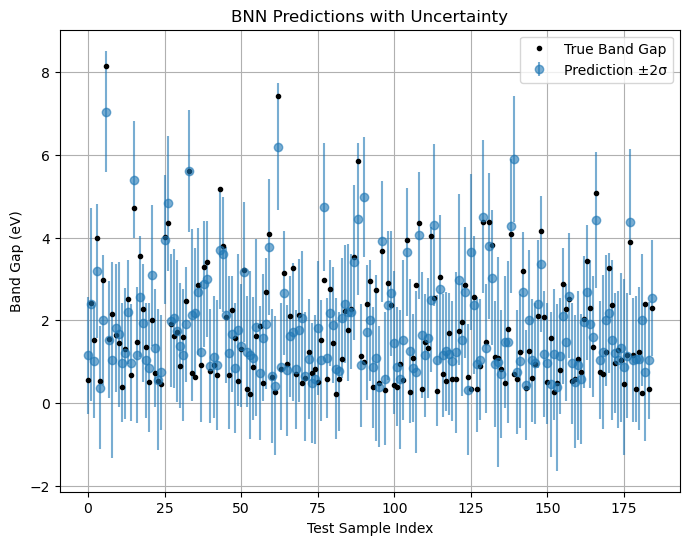

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(np.arange(len(mean_pred_actual)), mean_pred_actual, yerr=2*std_pred_actual, fmt='o', label="Prediction ±2σ", alpha=0.6)
plt.plot(np.arange(len(y_test_actual)), y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()


#### Compute log-likelihood

For original data: 

Total Log-Likelihood (Test): -151.10
Average Log-Likelihood per Sample: -0.8168
Negative Log-Likelihood (NLL): 151.10
Average NLL per Sample: 0.8168


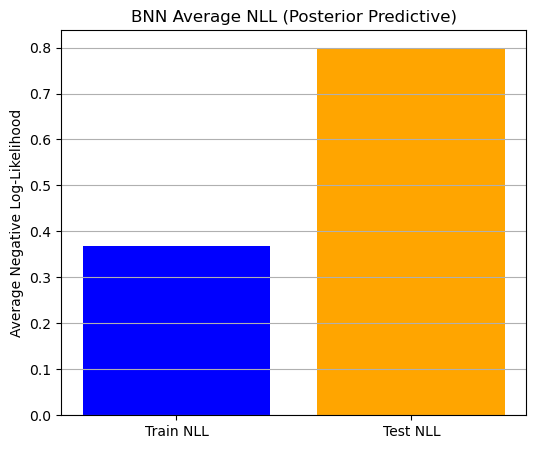

Average Train NLL: 0.3684
Average Test NLL: 0.7977


In [ ]:

test_preds = predictive(X_test_tensor)["obs"]  # shape: [num_samples, num_test_points]

# Mean and std from posterior predictive samples
mean_pred = test_preds.mean(dim=0)
std_pred = test_preds.std(dim=0) + 1e-6  # avoid log(0)

# Assume Gaussian predictive distribution
likelihood = dist.Normal(mean_pred, std_pred)

# Convert true y_test values (already standardized) to tensor
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Compute log-probability of true values under the predictive distribution
log_probs = likelihood.log_prob(y_test_tensor)  # shape: [num_test_points]

# Compute total and average log-likelihood
log_likelihood_total = log_probs.sum().item()
log_likelihood_avg = log_probs.mean().item()
nll = -log_likelihood_total
nll_avg = -log_likelihood_avg

print(f"Total Log-Likelihood (Test): {log_likelihood_total:.2f}")
print(f"Average Log-Likelihood per Sample: {log_likelihood_avg:.4f}")
print(f"Negative Log-Likelihood (NLL): {nll:.2f}")
print(f"Average NLL per Sample: {nll_avg:.4f}")

#Get all posterior predictive samples for train and test
predictive = Predictive(model, posterior_samples, return_sites=["obs"])
train_preds = predictive(X_train_tensor)["obs"]  # shape: [num_samples, num_train_points]
test_preds = predictive(X_test_tensor)["obs"]    # shape: [num_samples, num_test_points]

# Compute mean and std for each data point across posterior samples
train_mean = train_preds.mean(dim=0)
train_std = train_preds.std(dim=0) + 1e-6
test_mean = test_preds.mean(dim=0)
test_std = test_preds.std(dim=0) + 1e-6

# Compute NLL for each data point
train_likelihood = dist.Normal(train_mean, train_std)
test_likelihood = dist.Normal(test_mean, test_std)

# Ensure targets are tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Log-probabilities for each data point
train_log_probs = train_likelihood.log_prob(y_train_tensor)
test_log_probs = test_likelihood.log_prob(y_test_tensor)

# Average NLL
train_nll = -train_log_probs.mean().item()
test_nll = -test_log_probs.mean().item()

# Plot
plt.figure(figsize=(6, 5))
plt.bar(['Train NLL', 'Test NLL'], [train_nll, test_nll], color=['blue', 'orange'])
plt.ylabel("Average Negative Log-Likelihood")
plt.title("BNN Average NLL (Posterior Predictive)")
plt.grid(axis='y')
plt.show()

print(f"Average Train NLL: {train_nll:.4f}")
print(f"Average Test NLL: {test_nll:.4f}")


In [ ]:
mean_pred = preds.mean(dim=0).numpy()  # predictive mean
mean_pred_actual = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

from sklearn.metrics import r2_score
r2 = r2_score(y_test_actual, mean_pred_actual)
print("R² score:", r2)

For log-transformed data 

In [ ]:
"""# Ensure targets are tensors (in standardized log space)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Get all posterior predictive samples for train and test
predictive = Predictive(model, posterior_samples, return_sites=["obs"])
train_preds = predictive(X_train_tensor)["obs"]  # shape: [num_samples, num_train_points]
test_preds = predictive(X_test_tensor)["obs"]    # shape: [num_samples, num_test_points]

# Compute mean and std for each point across posterior samples
train_mean = train_preds.mean(dim=0)
train_std = train_preds.std(dim=0).clamp(min=1e-6)  # avoid numerical issues
test_mean = test_preds.mean(dim=0)
test_std = test_preds.std(dim=0).clamp(min=1e-6)

# Predictive Normal distributions
train_likelihood = dist.Normal(train_mean, train_std)
test_likelihood = dist.Normal(test_mean, test_std)

# Log-probabilities for each data point
train_log_probs = train_likelihood.log_prob(y_train_tensor)
test_log_probs = test_likelihood.log_prob(y_test_tensor)

# === Compute NLL
train_nll = -train_log_probs.mean().item()
test_nll = -test_log_probs.mean().item()

# Total log-likelihoods (optional)
total_train_ll = train_log_probs.sum().item()
total_test_ll = test_log_probs.sum().item()

# === Print results
print(f"Average Train NLL: {train_nll:.4f}")
print(f"Average Test NLL: {test_nll:.4f}")
print(f"Total Train Log-Likelihood: {total_train_ll:.2f}")
print(f"Total Test Log-Likelihood: {total_test_ll:.2f}")

# === Plot NLL comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.bar(['Train NLL', 'Test NLL'], [train_nll, test_nll], color=['blue', 'orange'])
plt.ylabel("Average Negative Log-Likelihood")
plt.title("BNN Average NLL (Posterior Predictive)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()"""

'# Ensure targets are tensors (in standardized log space)\ny_train_tensor = torch.tensor(y_train, dtype=torch.float32)\ny_test_tensor = torch.tensor(y_test, dtype=torch.float32)\n\n# Get all posterior predictive samples for train and test\npredictive = Predictive(model, posterior_samples, return_sites=["obs"])\ntrain_preds = predictive(X_train_tensor)["obs"]  # shape: [num_samples, num_train_points]\ntest_preds = predictive(X_test_tensor)["obs"]    # shape: [num_samples, num_test_points]\n\n# Compute mean and std for each point across posterior samples\ntrain_mean = train_preds.mean(dim=0)\ntrain_std = train_preds.std(dim=0).clamp(min=1e-6)  # avoid numerical issues\ntest_mean = test_preds.mean(dim=0)\ntest_std = test_preds.std(dim=0).clamp(min=1e-6)\n\n# Predictive Normal distributions\ntrain_likelihood = dist.Normal(train_mean, train_std)\ntest_likelihood = dist.Normal(test_mean, test_std)\n\n# Log-probabilities for each data point\ntrain_log_probs = train_likelihood.log_prob(y_train

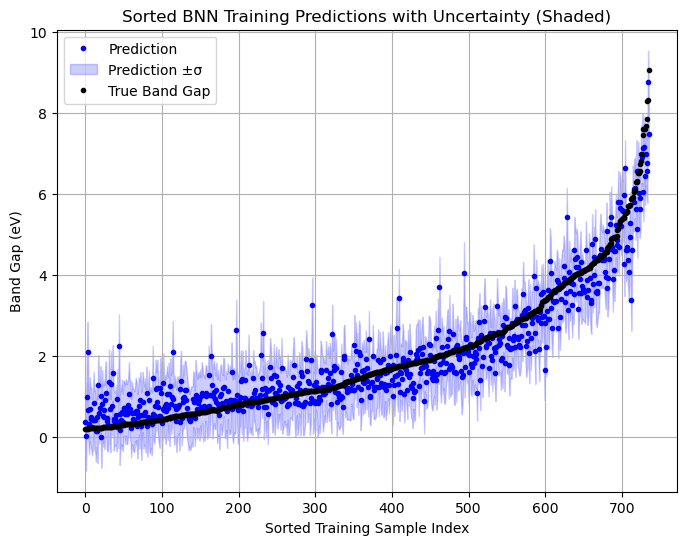

In [ ]:
# Get posterior predictions on training data
preds_train = predictive(X_train_tensor)["obs"]
mean_pred_train = preds_train.mean(dim=0).numpy()
std_pred_train = preds_train.std(dim=0).numpy()

# Inverse-transform
mean_pred_train_actual = scaler_y.inverse_transform(mean_pred_train.reshape(-1, 1)).ravel()
std_pred_train_actual = std_pred_train * scaler_y.scale_[0]
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()

# Sort by true values for plotting
sorted_indices = np.argsort(y_train_actual)
sorted_mean_pred_actual = mean_pred_train_actual[sorted_indices]
sorted_std_pred_actual = std_pred_train_actual[sorted_indices]
sorted_y_train_actual = y_train_actual[sorted_indices]

# Compute bounds for uncertainty region (±1σ or use ±2σ if preferred)
x = np.arange(len(sorted_mean_pred_actual))
upper = sorted_mean_pred_actual + sorted_std_pred_actual
lower = sorted_mean_pred_actual - sorted_std_pred_actual

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_train_actual, 'k.', label="True Band Gap")
plt.xlabel("Sorted Training Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("Sorted BNN Training Predictions with Uncertainty (Shaded)")
plt.legend()
plt.grid(True)
plt.show()


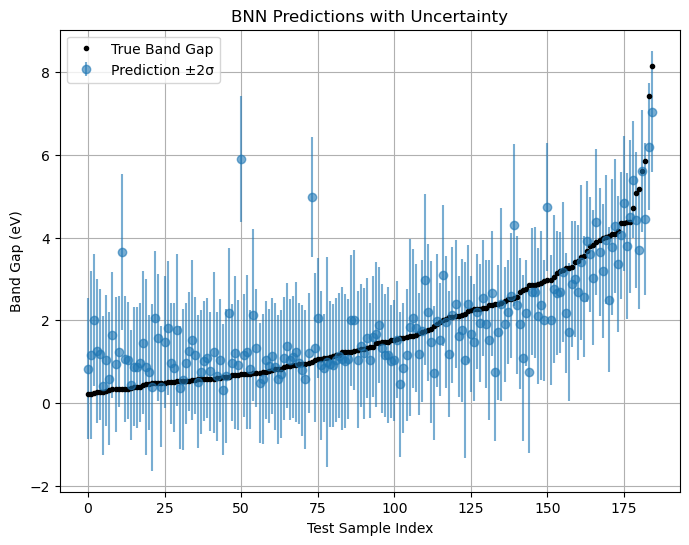

In [ ]:
sorted_indices = np.argsort(y_test_actual)
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
sorted_std_pred_actual = std_pred_actual[sorted_indices]
# Plot with confidence interval
plt.figure(figsize=(8, 6))
plt.errorbar(np.arange(len(sorted_mean_pred_actual)), sorted_mean_pred_actual, yerr=2*sorted_std_pred_actual, fmt='o', label="Prediction ±2σ", alpha=0.6)
plt.plot(np.arange(len(sorted_y_test_actual)), sorted_y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

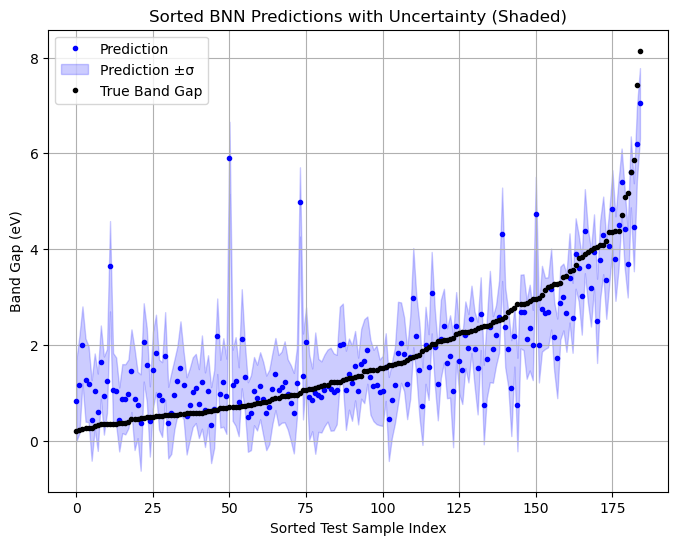

In [ ]:
x = np.arange(len(sorted_mean_pred_actual))
upper = sorted_mean_pred_actual + sorted_std_pred_actual
lower = sorted_mean_pred_actual - sorted_std_pred_actual

plt.figure(figsize=(8, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("Sorted BNN Predictions with Uncertainty (Shaded)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#get information about outliers 
outliers = np.abs(sorted_mean_pred_actual - sorted_y_test_actual) > 1.5 # Define outliers as those with a difference greater than 0.2 eV
outlier_indices = np.where(outliers)[0]
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
print("Outlier Indices:", outlier_indices)
print("Outlier Predictions:", sorted_mean_pred_actual[outlier_indices])
print("Outlier True Values:", sorted_y_test_actual[outlier_indices])


Outlier Indices: [  2  11  22  46  50  73 133 139 142 144 150 157 170]
Outlier Predictions: [2.0036821  3.6409519  2.0502534  2.17866    5.898217   4.9832125
 0.75217545 4.307995   1.0947844  0.75286174 4.7340884  1.7164037
 2.4999235 ]
Outlier True Values: [0.2312 0.3474 0.4773 0.6412 0.6975 1.0035 2.3853 2.5394 2.7295 2.8504
 2.9654 3.2749 4.0339]


In [ ]:
outlier_test_indices = sorted_indices[outlier_indices]

In [ ]:
# Map test index to original DataFrame index
outlier_original_indices = idx_test[outlier_test_indices]


#### Plot shading ±1 standard deviation (σ) (68% confidence)

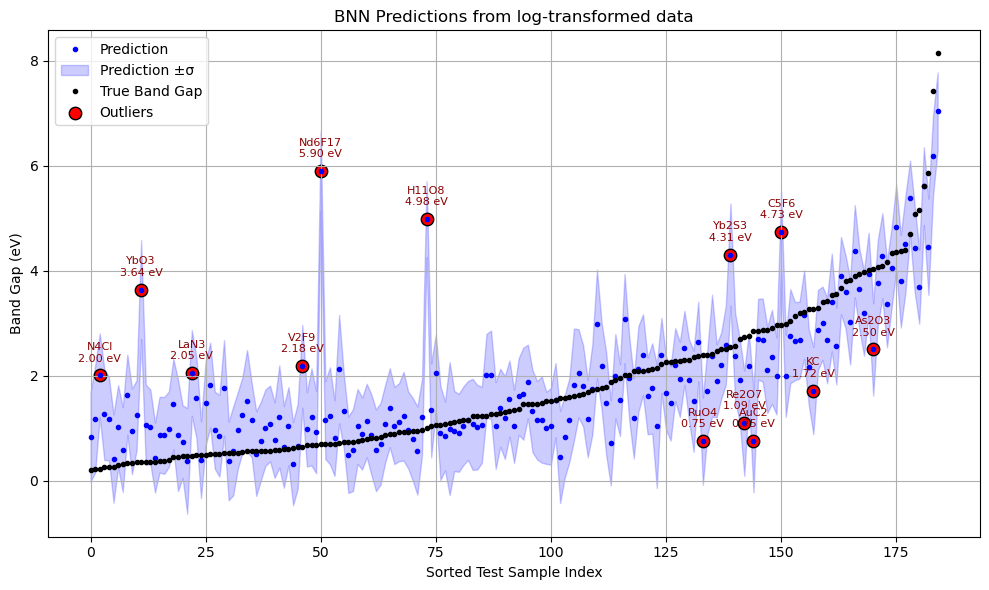

In [ ]:
# Map sorted → test → original index
outlier_test_indices = sorted_indices[outlier_indices]
outlier_original_indices = idx_test[outlier_test_indices]

# Get pretty formulas from original dataset
formulas = df_mp.iloc[outlier_original_indices]["formula_pretty"].values

# Plot predictions and uncertainty
x = np.arange(len(sorted_mean_pred_actual))
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]
outlier_preds = sorted_mean_pred_actual[outlier_indices]

plt.figure(figsize=(10, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")
plt.scatter(x[outlier_indices], outlier_preds, color='red', edgecolor='black', s=80, label='Outliers')

# Annotate each outlier with formula and predicted band gap
for i, idx in enumerate(outlier_indices):
    pred_val = sorted_mean_pred_actual[idx]
    formula = formulas[i]
    plt.annotate(
        f"{formula}\n{pred_val:.2f} eV",
        (x[idx], pred_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkred'
    )

# Formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions from log-transformed data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



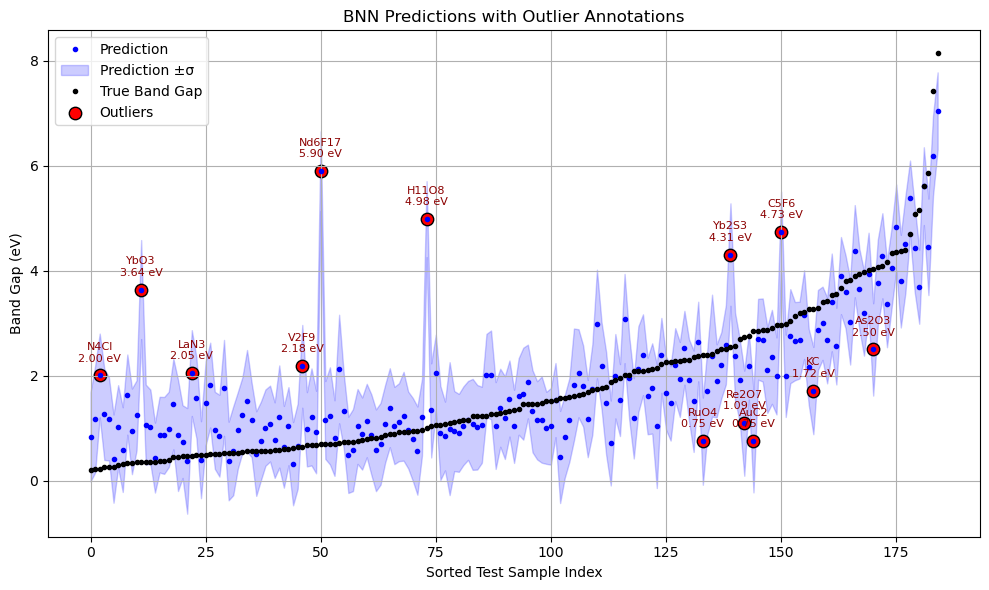

In [ ]:
# Sort both arrays using the same indices
sorted_indices = np.argsort(y_test_actual)
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
sorted_std_pred_actual = std_pred_actual[sorted_indices]

# Now you can safely subtract
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5  # > 1.5 eV difference is considered an outlier
outlier_indices = np.where(outlier_mask)[0]  # indices in the sorted array
outlier_preds = sorted_mean_pred_actual[outlier_indices]

# === Map sorted test indices → original dataset row indices ===
outlier_test_indices = sorted_indices[outlier_indices]           # in X_test
outlier_original_indices = idx_test[outlier_test_indices]        # in df_mp

# === Retrieve formulas using original indices ===
formulas = df_mp.iloc[outlier_original_indices]["formula_pretty"].values

# === Plot predictions with uncertainty and annotate outliers ===
x = np.arange(len(sorted_mean_pred_actual))
upper = sorted_mean_pred_actual + sorted_std_pred_actual
lower = sorted_mean_pred_actual - sorted_std_pred_actual

plt.figure(figsize=(10, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")
plt.scatter(x[outlier_indices], outlier_preds, color='red', edgecolor='black', s=80, label='Outliers')

# Annotate outliers
for i, idx in enumerate(outlier_indices):
    pred_val = sorted_mean_pred_actual[idx]
    formula = formulas[i]
    plt.annotate(
        f"{formula}\n{pred_val:.2f} eV",
        (x[idx], pred_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkred'
    )

# === Plot formatting ===
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Outlier Annotations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


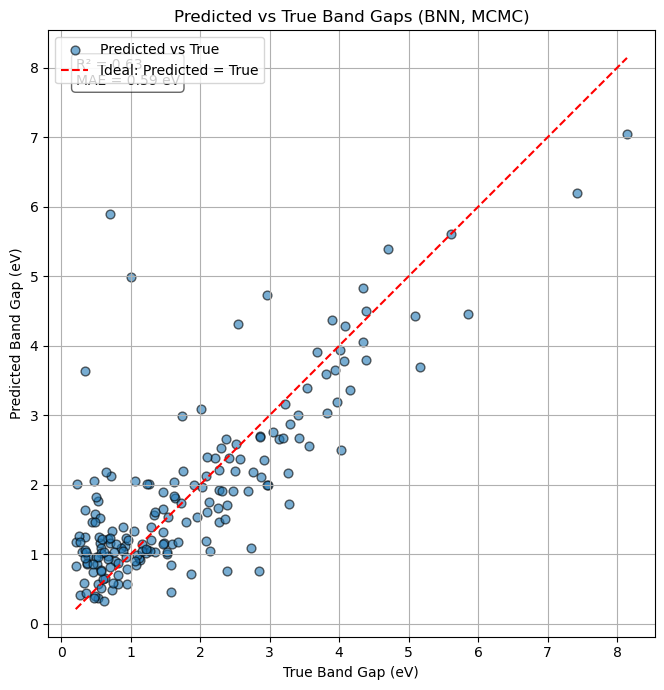

In [ ]:
# mean_pred_actual: predicted mean band gaps (already inverse-transformed to eV)
# y_test_actual: true band gaps (already inverse-transformed to eV)

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate stats
r2 = r2_score(y_test_actual, mean_pred_actual)
mae = mean_absolute_error(y_test_actual, mean_pred_actual)

# Determine axis limits with padding
min_val = min(y_test_actual.min(), mean_pred_actual.min())
max_val = max(y_test_actual.max(), mean_pred_actual.max())
padding = (max_val - min_val) * 0.05

# Create plot
plt.figure(figsize=(7, 7))
plt.scatter(y_test_actual, mean_pred_actual, alpha=0.6, s=40, edgecolor='k', label="Predicted vs True")

# Plot ideal prediction line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal: Predicted = True")

# Axis labels and title
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Predicted vs True Band Gaps (BNN, MCMC)")

# Set limits and equal aspect ratio
plt.xlim(min_val - padding, max_val + padding)
plt.ylim(min_val - padding, max_val + padding)
plt.gca().set_aspect('equal', adjustable='box')

# Annotate with R² and MAE
plt.text(min_val, max_val, f"R² = {r2:.2f}\nMAE = {mae:.2f} eV",
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.6))

# Final touches
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Compute absolute error and define outliers
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5  # Define your outlier threshold here
outlier_indices_sorted = np.where(outlier_mask)[0]

# Map sorted index → test index → original dataset index
outlier_test_indices = sorted_indices[outlier_indices_sorted]
outlier_original_indices = idx_test[outlier_test_indices]

#Extract info from the original DataFrame
compositions = df_mp.iloc[outlier_original_indices]["formula_pretty"].values
true_bandgaps = sorted_y_test_actual[outlier_indices_sorted]
predicted_bandgaps = sorted_mean_pred_actual[outlier_indices_sorted]

#Build the summary table
outliers_df = pd.DataFrame({
    "outlier_index": outlier_indices,
    "original_index": outlier_original_indices,
    "formula": compositions,
    "true_band_gap": true_bandgaps,
    "predicted_band_gap": predicted_bandgaps, 
    "absolute error": predicted_bandgaps - true_bandgaps

})


print(outliers_df.sort_values(by="true_band_gap"))


    outlier_index  original_index formula  true_band_gap  predicted_band_gap  \
0               2             907    N4Cl         0.2312            2.003682   
1              11             819    YbO3         0.3474            3.640952   
2              22             796    LaN3         0.4773            2.050253   
3              46             757    V2F9         0.6412            2.178660   
4              50             790  Nd6F17         0.6975            5.898217   
5              73             765   H11O8         1.0035            4.983212   
6             133             467    RuO4         2.3853            0.752175   
7             139             388   Yb2S3         2.5394            4.307995   
8             142             334   Re2O7         2.7295            1.094784   
9             144             916    AuC2         2.8504            0.752862   
10            150             829    C5F6         2.9654            4.734088   
11            157             850      K

#### Plot shading 95% confidence interval 

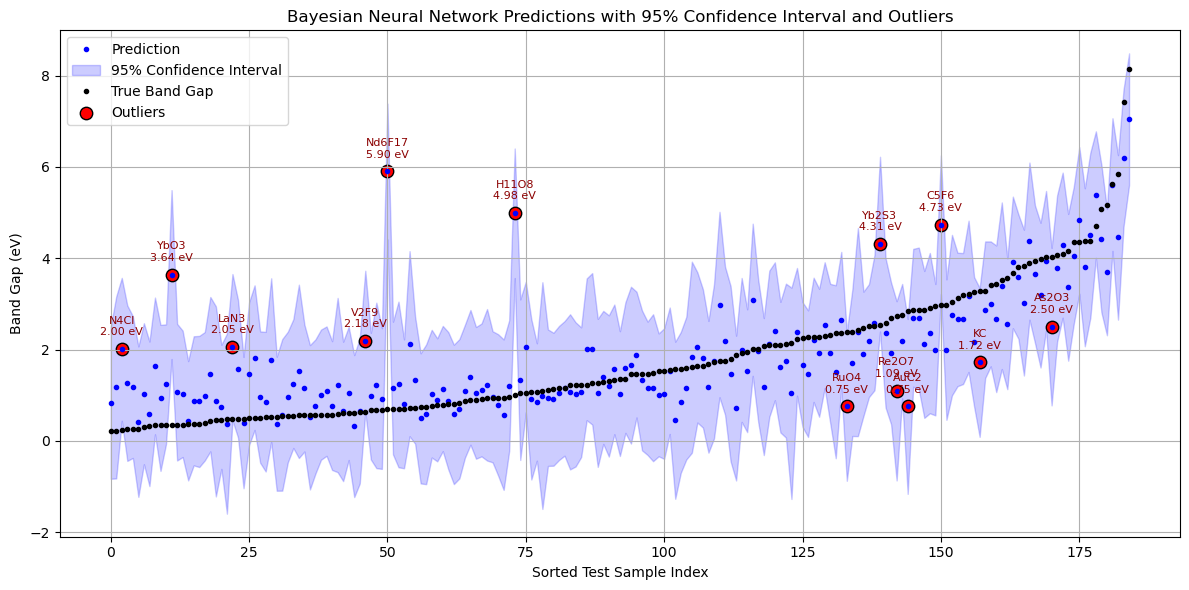

In [ ]:
# Define 95% confidence interval bounds (assuming normal distribution)
lower = sorted_mean_pred_actual - 1.96 * sorted_std_pred_actual
upper = sorted_mean_pred_actual + 1.96 * sorted_std_pred_actual

# Compute absolute prediction errors
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)

# Identify outliers with error > 1.5 eV
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]
outlier_preds = sorted_mean_pred_actual[outlier_indices]

# Map sorted → test → original index
outlier_test_indices = sorted_indices[outlier_indices]
outlier_original_indices = idx_test[outlier_test_indices]

# Get chemical formulas for outliers from original dataframe
formulas = df_mp.iloc[outlier_original_indices]["formula_pretty"].values

# X-axis: just indices of sorted test points
x = np.arange(len(sorted_mean_pred_actual))

# Plot
plt.figure(figsize=(12, 6))

# Mean prediction
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")

# 95% Confidence interval
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="95% Confidence Interval")

# True values
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")

# Outliers
plt.scatter(x[outlier_indices], outlier_preds, color='red', edgecolor='black', s=80, label='Outliers')


# Annotate outliers with formula and prediction
for i, idx in enumerate(outlier_indices):
    pred_val = sorted_mean_pred_actual[idx]
    formula = formulas[i]
    plt.annotate(
        f"{formula}\n{pred_val:.2f} eV",
        (x[idx], pred_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkred'
    )


# Formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("Bayesian Neural Network Predictions with 95% Confidence Interval and Outliers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
